# Demand Forecasting and Price Elastictity Analysis Using Time Series Regression 
This notebook is a tutorial on demand forecasting and price elasticity analysis using time series regression (regression models trained on a sliding window). We use a real-world dataset and focus on proper data preparation and pre-filtering.

### Data
We use a dataset created based on statistics from the `Olist E-Commerce` dataset (see `datasets.md` for details). The files are  available in the `tensor-house-data` repository under `pricing/ecommerce-orders` folder.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
plt.style.use('seaborn-white')
import seaborn as sns
pd.options.mode.chained_assignment = None
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from tabulate import tabulate
import datetime

from sklearn.model_selection import train_test_split
import lightgbm

import platform
print(f'Python {platform.python_version()}')

Python 3.10.2


In [61]:
#
# Helper functions
#
def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')

# Data Loading

In [288]:
data_path = '../../tensor-house-data/pricing/ecommerce-orders'
orders = pd.read_csv(f'{data_path}/ecommerce-sales-orders.csv.zip', compression='zip', parse_dates=['date'])
orders['year'] = orders['date'].dt.year.astype(np.int32)
orders['week'] = orders['date'].dt.isocalendar().week.astype(np.int32)
orders['date'] = orders['date'].dt.date

order_items = pd.read_csv(f'{data_path}/ecommerce-sales-order-items.csv.zip', compression='zip', parse_dates=[])

items = pd.read_csv(f'{data_path}/ecommerce-sales-products.csv.zip', compression='zip')

print_df(orders)
print_df(order_items)
print_df(items)

+----+------------+------------+--------+--------+
|    | date       |   order_id |   year |   week |
|----+------------+------------+--------+--------|
|  0 | 2017-10-02 |          0 |   2017 |     40 |
|  1 | 2018-07-24 |          1 |   2018 |     30 |
|  2 | 2018-08-08 |          2 |   2018 |     32 |
|  3 | 2017-11-18 |          3 |   2017 |     46 |
|  4 | 2018-02-13 |          4 |   2018 |      7 |
|  5 | 2017-07-09 |          5 |   2017 |     27 |
|  6 | 2017-04-11 |          6 |   2017 |     15 |
|  7 | 2017-05-16 |          7 |   2017 |     20 |
|  8 | 2017-01-23 |          8 |   2017 |      4 |
|  9 | 2017-07-29 |          9 |   2017 |     30 |
+----+------------+------------+--------+--------+
99441 rows x 4 columns
+----+---------+--------------+------------+
|    |   price |   product_id |   order_id |
|----+---------+--------------+------------|
|  0 |    58.9 |            0 |      85267 |
|  1 |    55.9 |            0 |      64197 |
|  2 |    64.9 |            0 |      1

# Data Cleansing and Pre-Filtering

In this section, we filter out inactive items and items with irregular demand patterns. More specialized forecasting techniques should be used for irregular patterns.

In [345]:
#
# Create a plain demand history layout
#
df = order_items.merge(orders, on='order_id', how='inner')
df['sales_units'] = 1
df.drop(columns=['order_id'], inplace=True)
df = df.groupby(['product_id', 'date']).agg({'price': 'max', 
                                             'year': 'max', 
                                             'week': 'max', 
                                             'sales_units': 'sum'}).reset_index()

print_df(df)
print('Unique products:', len(df['product_id'].unique()))

+----+--------------+------------+---------+--------+--------+---------------+
|    |   product_id | date       |   price |   year |   week |   sales_units |
|----+--------------+------------+---------+--------+--------+---------------|
|  0 |            0 | 2017-06-05 |    55.9 |   2017 |     23 |             1 |
|  1 |            0 | 2017-06-28 |    55.9 |   2017 |     26 |             1 |
|  2 |            0 | 2017-07-27 |    55.9 |   2017 |     30 |             1 |
|  3 |            0 | 2017-08-01 |    58.9 |   2017 |     31 |             1 |
|  4 |            0 | 2017-08-05 |    58.9 |   2017 |     31 |             1 |
|  5 |            0 | 2017-08-10 |    58.9 |   2017 |     32 |             1 |
|  6 |            0 | 2017-09-13 |    58.9 |   2017 |     37 |             1 |
|  7 |            0 | 2018-03-18 |    64.9 |   2018 |     11 |             1 |
|  8 |            0 | 2018-05-18 |    64.9 |   2018 |     20 |             1 |
|  9 |            1 | 2017-04-26 |   239.9 |   2017 

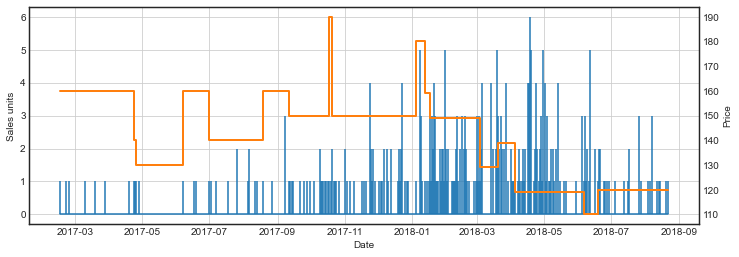

In [372]:
#
# Visualize an example price and sales history for one of the products
#
fig, ax1 = plt.subplots(1, figsize=(12, 4))
df_example_prod = df.query('product_id == 125')

ax1.set_xlabel('Date')
ax1.set_ylabel('Sales units')
ax1.stem(df_example_prod['date'], df_example_prod['sales_units'], linefmt='C0', markerfmt='none', basefmt='C0', label='Sales')
plt.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Price')
ax2.step(df_example_prod['date'], df_example_prod['price'], color='C1', where='post', linewidth=2, label='Price')

plt.show()

In [298]:
#
# Filter 1: active products that have, at minimum, ten weeks with at least 1 unit sold
#
df_week_counts = df.groupby(['product_id', 'year', 'week']).size().reset_index()
df_active_products = df_week_counts.groupby(['product_id']).size().reset_index(name='active_weeks').query('active_weeks >= 10')
df_active = df.merge(df_active_products['product_id'], on='product_id', how='inner')

print_df(df_active)
print('Unique products:', len(df_active['product_id'].unique()))

+----+--------------+------------+---------+--------+--------+---------------+
|    |   product_id | date       |   price |   year |   week |   sales_units |
|----+--------------+------------+---------+--------+--------+---------------|
|  0 |            4 | 2017-02-04 |   199.9 |   2017 |      5 |             1 |
|  1 |            4 | 2017-04-25 |   199.9 |   2017 |     17 |             1 |
|  2 |            4 | 2017-05-04 |   199.9 |   2017 |     18 |             1 |
|  3 |            4 | 2017-05-18 |   199.9 |   2017 |     20 |             1 |
|  4 |            4 | 2017-05-20 |   199.9 |   2017 |     20 |             1 |
|  5 |            4 | 2017-07-04 |   199.9 |   2017 |     27 |             1 |
|  6 |            4 | 2017-08-22 |   199.9 |   2017 |     34 |             1 |
|  7 |            4 | 2017-12-19 |   199.9 |   2017 |     51 |             1 |
|  8 |            4 | 2018-01-17 |   199.9 |   2018 |      3 |             1 |
|  9 |            4 | 2018-02-14 |   209.9 |   2018 

+--------------+------------+------------+-------------+--------------+---------------+-----------+----------+
|   product_id | date_min   | date_max   |   n_demands |   demand_std |   demand_mean |       cv2 |      adi |
|--------------+------------+------------+-------------+--------------+---------------+-----------+----------|
|            4 | 2017-02-04 | 2018-03-10 |          12 |     0        |       1       | 0         | 33.25    |
|           10 | 2017-07-16 | 2018-06-29 |          48 |     0.460785 |       1.14583 | 0.161716  |  7.25    |
|           12 | 2017-02-28 | 2018-08-19 |         268 |     1.24732  |       1.8209  | 0.469233  |  2.00373 |
|           13 | 2017-07-18 | 2018-08-25 |         178 |     2.18398  |       2.17978 | 1.00386   |  2.26404 |
|           16 | 2018-03-18 | 2018-06-22 |          18 |     0.323381 |       1.11111 | 0.0847059 |  5.33333 |
|           18 | 2017-06-07 | 2018-08-27 |          18 |     0.514496 |       1.16667 | 0.194478  | 24.7778  |
|

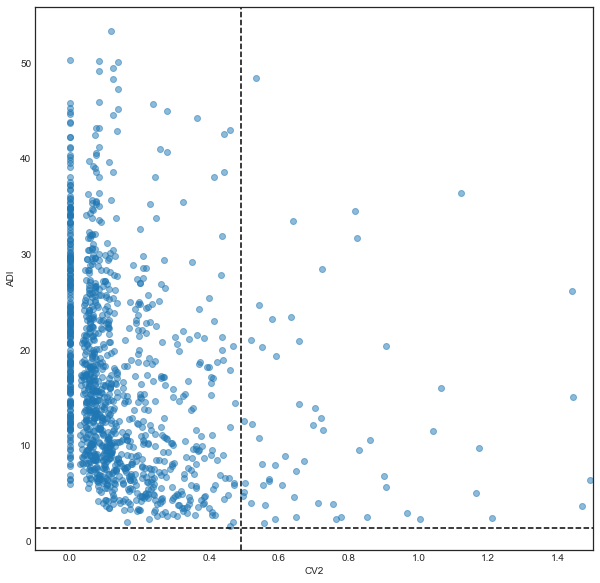

+----+--------------+------------+---------+--------+--------+---------------+
|    |   product_id | date       |   price |   year |   week |   sales_units |
|----+--------------+------------+---------+--------+--------+---------------|
|  0 |            4 | 2017-02-04 |   199.9 |   2017 |      5 |             1 |
|  1 |            4 | 2017-04-25 |   199.9 |   2017 |     17 |             1 |
|  2 |            4 | 2017-05-04 |   199.9 |   2017 |     18 |             1 |
|  3 |            4 | 2017-05-18 |   199.9 |   2017 |     20 |             1 |
|  4 |            4 | 2017-05-20 |   199.9 |   2017 |     20 |             1 |
|  5 |            4 | 2017-07-04 |   199.9 |   2017 |     27 |             1 |
|  6 |            4 | 2017-08-22 |   199.9 |   2017 |     34 |             1 |
|  7 |            4 | 2017-12-19 |   199.9 |   2017 |     51 |             1 |
|  8 |            4 | 2018-01-17 |   199.9 |   2018 |      3 |             1 |
|  9 |            4 | 2018-02-14 |   209.9 |   2018 

In [299]:
#
# Filter 2: Demand type, daily
#
def get_demand_metrics(df, date_column):
    df_dmetrics = df.groupby('product_id').agg(
        date_min=(date_column, 'min'),
        date_max=(date_column, 'max'),
        n_demands=(date_column, 'nunique'),
        demand_std=('sales_units', 'std'), 
        demand_mean=('sales_units', 'mean'))

    df_dmetrics['cv2'] = np.power(df_dmetrics['demand_std'] / df_dmetrics['demand_mean'], 2.0)
    time_delta = df_dmetrics['date_max'] - df_dmetrics['date_min']
    if pd.api.types.is_numeric_dtype(time_delta):
        df_dmetrics['adi'] = time_delta / df_dmetrics['n_demands']
    else:
        df_dmetrics['adi'] = time_delta.dt.days / df_dmetrics['n_demands']
    
    return df_dmetrics

def plot_demand_type(df_demand_metrics):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.scatter(df_demand_metrics['cv2'], df_demand_metrics['adi'], alpha = 0.5)
    ax.axhline(1.32, linestyle='--', color='k')
    ax.axvline(0.49, linestyle='--', color='k')
    ax.set_xlim([-0.1, 1.5])
    ax.set_xlabel('CV2')
    ax.set_ylabel('ADI')
    plt.show()
    
df_dmetrics = get_demand_metrics(df_active, 'date')
print_df(df_dmetrics)
plot_demand_type(df_dmetrics)

non_lumpy_products = df_dmetrics.query('adi < 1.39 or cv2 < 0.49').index
df_active_nonlumpy = df_active[df_active['product_id'].isin(non_lumpy_products)]
print_df(df_active_nonlumpy)
print('Unique products:', len(df_active_nonlumpy['product_id'].unique()))

+----+--------------+---------------------+---------------+---------+
|    |   product_id | date                |   sales_units |   price |
|----+--------------+---------------------+---------------+---------|
|  0 |            4 | 2017-01-30 00:00:00 |             1 |   199.9 |
|  1 |            4 | 2017-04-24 00:00:00 |             1 |   199.9 |
|  2 |            4 | 2017-05-01 00:00:00 |             1 |   199.9 |
|  3 |            4 | 2017-05-15 00:00:00 |             2 |   199.9 |
|  4 |            4 | 2017-07-03 00:00:00 |             1 |   199.9 |
|  5 |            4 | 2017-08-21 00:00:00 |             1 |   199.9 |
|  6 |            4 | 2017-12-18 00:00:00 |             1 |   199.9 |
|  7 |            4 | 2018-01-15 00:00:00 |             1 |   199.9 |
|  8 |            4 | 2018-02-12 00:00:00 |             2 |   209.9 |
|  9 |            4 | 2018-03-05 00:00:00 |             1 |   209.9 |
+----+--------------+---------------------+---------------+---------+
20288 rows x 4 colum

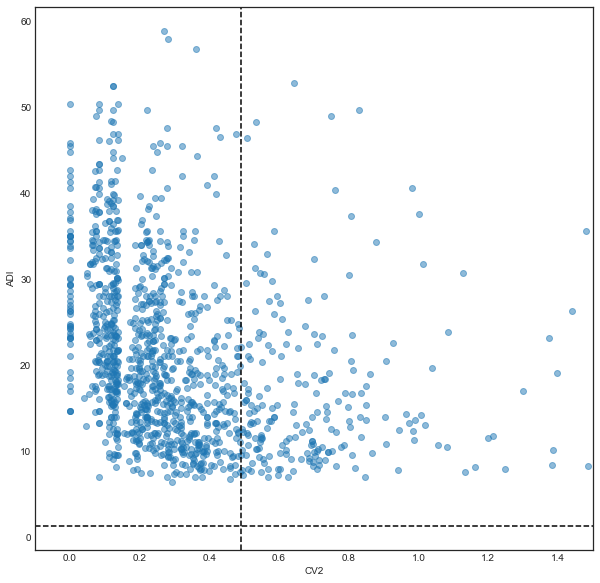

+----+--------------+---------------------+---------------+---------+
|    |   product_id | date                |   sales_units |   price |
|----+--------------+---------------------+---------------+---------|
|  0 |            4 | 2017-01-30 00:00:00 |             1 |   199.9 |
|  1 |            4 | 2017-04-24 00:00:00 |             1 |   199.9 |
|  2 |            4 | 2017-05-01 00:00:00 |             1 |   199.9 |
|  3 |            4 | 2017-05-15 00:00:00 |             2 |   199.9 |
|  4 |            4 | 2017-07-03 00:00:00 |             1 |   199.9 |
|  5 |            4 | 2017-08-21 00:00:00 |             1 |   199.9 |
|  6 |            4 | 2017-12-18 00:00:00 |             1 |   199.9 |
|  7 |            4 | 2018-01-15 00:00:00 |             1 |   199.9 |
|  8 |            4 | 2018-02-12 00:00:00 |             2 |   209.9 |
|  9 |            4 | 2018-03-05 00:00:00 |             1 |   209.9 |
+----+--------------+---------------------+---------------+---------+
15476 rows x 4 colum

In [419]:
#
# For the sake of illustration, we also examine how the demand patters 
# are distributed for weekly aggregates 
#
df_weekly = df_active.copy()

# Date is the week start date
df_weekly['date'] = pd.to_datetime(df_weekly['date']).dt.to_period('W').dt.start_time
df_weekly = df_weekly.groupby(['product_id', 'date']).agg({'sales_units': 'sum', 'price': 'mean'}).reset_index()

print_df(df_weekly)

df_dmetrics = get_demand_metrics(df_weekly, 'date')
plot_demand_type(df_dmetrics)

non_lumpy_products_weekly = df_dmetrics.query('adi < 1.39 or cv2 < 0.49').index
df_active_nonlumpy_weekly = df_weekly[df_weekly['product_id'].isin(non_lumpy_products_weekly)]
print_df(df_active_nonlumpy_weekly)
print('Unique products:', len(df_active_nonlumpy_weekly['product_id'].unique()))

In [658]:
#
# Filter 3: 
# - Products that changed their price at least 6 times
# - Products that had sales for at least 15 weeks
#
df_active_variable_products = df_active_nonlumpy_weekly.groupby('product_id').agg(n_prices = ('price', 'nunique'), n_weeks = ('date', 'nunique')).query('n_prices >= 6 & n_weeks >= 15')
df_active_variable = df_active_nonlumpy_weekly[df_active_nonlumpy_weekly['product_id'].isin(df_active_variable_products.index)]

df_active_variable = df_active_variable.merge(items, on='product_id', how='left')

print_df(df_active_variable, rows=10)
print('Unique products:', len(df_active_variable['product_id'].unique()))

+----+--------------+---------------------+---------------+---------+-----------------+---------------+
|    |   product_id | date                |   sales_units |   price | category_name   |   category_id |
|----+--------------+---------------------+---------------+---------+-----------------+---------------|
|  0 |          109 | 2017-06-05 00:00:00 |             1 |   119.9 | health_beauty   |            13 |
|  1 |          109 | 2017-06-19 00:00:00 |             1 |   119.9 | health_beauty   |            13 |
|  2 |          109 | 2017-06-26 00:00:00 |             2 |   119.9 | health_beauty   |            13 |
|  3 |          109 | 2017-07-03 00:00:00 |             1 |   119.9 | health_beauty   |            13 |
|  4 |          109 | 2017-07-10 00:00:00 |             2 |   119.9 | health_beauty   |            13 |
|  5 |          109 | 2017-07-24 00:00:00 |             1 |   116.9 | health_beauty   |            13 |
|  6 |          109 | 2017-08-07 00:00:00 |             2 |   11

# Demand Forecasting and Elasticity Analysis

In this section, we fit a LightGBM model and use it to build an elasticity profle for one of the products.

In [951]:
# 
# Features
#
df_tmp = df_active_variable.groupby(['product_id'])['sales_units'].shift(1).rolling(1).mean().reset_index()
df_lags = df_active_variable.join(df_tmp.rename(columns={'sales_units':'sales_lag'}).drop(columns=['index']))

X = df_lags[['product_id', 'category_id', 'date', 'price', 'sales_lag']]
y = df_lags[['sales_units']]

X['year'] = pd.to_datetime(X['date']).dt.year
X['month'] = pd.to_datetime(X['date']).dt.month
X['week'] = pd.to_datetime(X['date']).dt.isocalendar().week.astype(np.int32)
X['price_log'] = np.log(X['price'])
X.drop(columns=['date', 'price'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/ikatsov/anaconda/envs/py310/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/ikatsov/anaconda/envs/py310/lib/python3.10/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


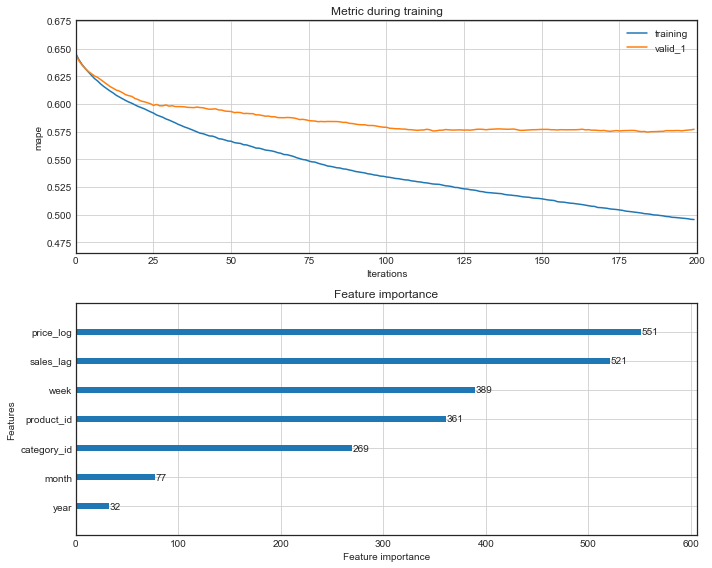

In [970]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': ['mse', 'mape'],
    'num_leaves': 12,
    'learning_rate': 0.05,
    'verbosity': -1
}
    
ds_train = lightgbm.Dataset(X_train, y_train)
ds_test = lightgbm.Dataset(X_test, y_test)
    
evals_result = {}
model = lightgbm.train(
              params = params,
              train_set = ds_train, 
              valid_sets = [ds_train, ds_test],
              num_boost_round = 200,
              evals_result = evals_result,
              verbose_eval = False,
)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
lightgbm.plot_metric(evals_result, metric='mape', ax=ax[0])
lightgbm.plot_importance(model, ax=ax[1])
plt.tight_layout()

plt.savefig('features.pdf')
plt.show()

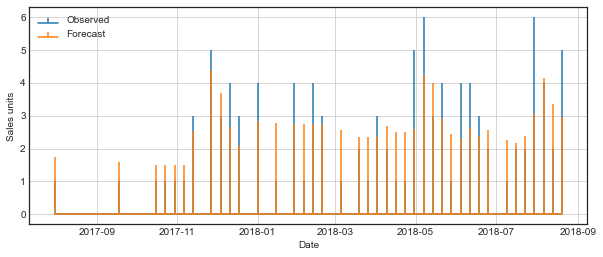

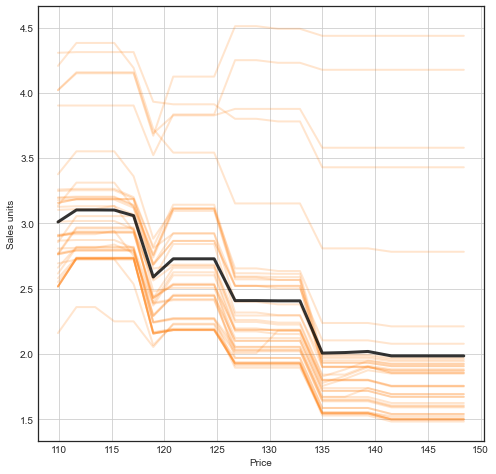

In [969]:
product_id = 216

#
# Visuaize the in-sample demand forecast
#
X_validate = X.query('product_id == @product_id')
sales_units_hat = model.predict(X_validate)
sales_units = df_active_variable.query('product_id == @product_id')

forecast = X_validate.copy()
forecast['sales_units_hat'] = sales_units_hat
forecast['sales_units'] = sales_units['sales_units']
forecast['price'] = sales_units['price']
forecast['date'] = sales_units['date']

fig, ax = plt.subplots(1, figsize=(10, 4))
ax.stem(forecast['date'], forecast['sales_units'], linefmt='C0', markerfmt='none', basefmt='C0', label='Observed')
ax.stem(forecast['date'], forecast['sales_units_hat'], linefmt='C1', markerfmt='none', basefmt='C1', label='Forecast')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales units')
ax.grid(True)

plt.savefig('demand.pdf')

#
# Visualizing the price elasticty function
#
fig, ax = plt.subplots(1, figsize=(8, 8))

item_log_prices = X.query('product_id == @product_id')['price_log']
price_logs = np.linspace(item_log_prices.min(), np.ceil(item_log_prices.max()), 20)
market_responses = []
for x in np.array(X.query('product_id == @product_id')):
    X_validate = []
    for price_log in price_logs:
        X_validate.append(x.copy())
        X_validate[-1][-1] = price_log
        
    X_validate = np.array(X_validate)

    sales_units_hat = model.predict(X_validate)
    market_responses.append(sales_units_hat)

    ax.plot(np.exp(price_logs), sales_units_hat, color='C1', linewidth=2, alpha=0.2)
    
ax.plot(np.exp(price_logs), np.mean(market_responses, axis=0), color='k', linewidth=3, alpha=0.8)
    
ax.grid(True)
ax.set_xlabel('Price')
ax.set_ylabel('Sales units')

plt.savefig('response.pdf')